# Real data

In this notebook, we work with two real data sets, the nursery dataset available at https://archive.ics.uci.edu/ml/datasets/Nursery and the mushroom dataset https://archive.ics.uci.edu/ml/datasets/Mushroom

In [1]:
from env import *
from agent import *
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import KFold
from skmultiflow.trees import HoeffdingTreeClassifier
%matplotlib inline

iteration = lambda s : int(re.split('_', s[:-4])[-1])

## Nursery Dataset

In the nursery dataset, we have a multi-class classification problem with 4 classes and 8 attributes such that $k_0=3, k_1=5, k_2=4, k_3=4, k_4=3, k_5=2, k_6=3, k_7=3$, hence the state space is of size $|\mathcal{S}| = 12960$. Thus we decide to apply Q-Learning to this problem

Let's start by loading the data and split it into training and testing data sets. Then we deduce the categories from the training set and define the rewards of queries.

In [2]:
data = np.genfromtxt('../data/nursery.data', delimiter=',', dtype=str)
data = data[data[:, -1] != 'recommend', :]
np.random.seed(0)
np.random.shuffle(data)  
data_train, data_test = data[:10000, :], data[10000:, :]

In [3]:
categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

Now let's define the environment and the agent.

In [4]:
env = EnvironmentReal(data_train, rewards_queries, r_plus=5, r_minus=-10)
agent = QLearning(categories=categories, labels=list(env.maps[data.shape[1]-1].values()), min_queries=1, max_queries=5)

We are ready to train the model, we will make three passes over the data stream induced from the whole training set.

In [5]:
n_episodes = data_train.shape[0]
agent.train(env, n_episodes, path_save='nursery_ql/', n_save=data_train.shape[0]//5, decay_rate=1e-4, epsilon_start=1, epsilon_stop=.1)

Episode : 0 , epsilon : 1.000
Episode : 2000 , epsilon : 0.431
Episode : 4000 , epsilon : 0.222
Episode : 6000 , epsilon : 0.145
Episode : 8000 , epsilon : 0.116


Take the greedy policy.

In [6]:
agent.greedy_policy()

Let's define the test environment and evaluate the model on unseen real data.

In [7]:
env_test = EnvironmentReal(data_test, rewards_queries)
print("accuracy=%.4f" %(agent.test(env_test, data_test.shape[0])))

accuracy=0.8915


We can visualize the decision tree that the agent converged to below.

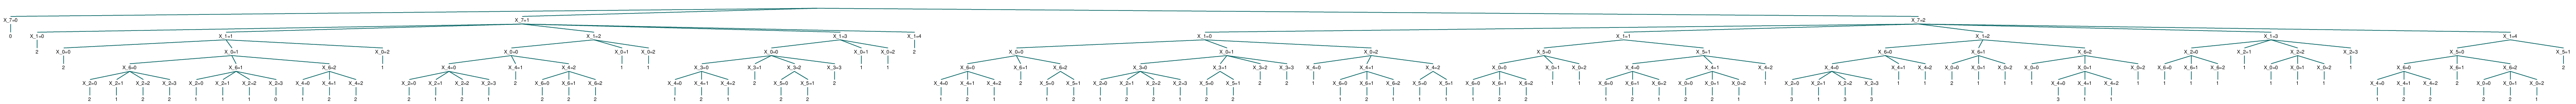

In [8]:
agent.plot_tree()

Let's take a look at the accuracy evolution of the agent during training.

In [8]:
accuracies_train = []
accuracies_test = []
iterations = []
list_weights = sorted(os.listdir('nursery_ql/'), key = iteration)

In [9]:
for i, path in enumerate(list_weights):
    agent.load_weights('nursery_ql/' + path)
    agent.greedy_policy()
    accuracies_train.append(agent.test(env, n_test=data_train.shape[0]))
    accuracies_test.append(agent.test(env_test, n_test=data_test.shape[0]))
    iterations.append(iteration(path))

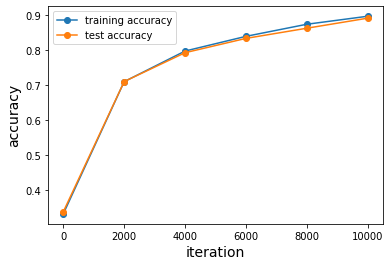

In [10]:
plt.plot(iterations, accuracies_train, 'o-', label='training accuracy')
plt.plot(iterations, accuracies_test, 'o-', label='test accuracy')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
plt.show()

Let's compare with Hoeffding trees, we start by processing the data to get a copy containing only numerical values.

In [7]:
# Let's make a processed copy of data containing only numerical values
# We need this processed copy in order to use HT
X_processed, Y_processed = np.empty_like(data[:, :-1], dtype=np.int), np.empty_like(data[:, -1], dtype=np.int)
for i in range(len(Y_processed)):
    a, b = env.preprocess(data[i, :])
    X_processed[i, :], Y_processed[i] = np.array(a, dtype=np.int), int(b)
    
X_train, Y_train = X_processed[:10000, :], Y_processed[:10000]
X_test, Y_test = X_processed[10000:, :], Y_processed[10000:]

Define the HT classifier, fit it on the data and calculate its accuracy on the test set.

In [8]:
ht = HoeffdingTreeClassifier()
ht.fit(X_train, Y_train)
predictions = ht.predict(X_test)
print("accuracy=%.4f" %((predictions == Y_test).sum()/len(predictions)))

accuracy=0.8499


Notice that the accuracy achieved with HT is around $85\%$ while the accuracy achieved with QLearning is around $89\%$

Now let's take a look at the evolution of the train and test accuracies for HT and compare it to that of QLearning.

In [13]:
ht = HoeffdingTreeClassifier()
accuracies_ht_train, accuracies_ht_test = [], []
predictions_train = ht.predict(X_train)
predictions_test = ht.predict(X_test)
accuracies_ht_train.append((predictions_train == Y_train).sum()/len(predictions_train))
accuracies_ht_test.append((predictions_test == Y_test).sum()/len(predictions_test))

In [14]:
for i in range(5):
#     print(X_train[i*X_train.shape[0]//5:(i+1)*X_train.shape[0]//5, :].shape)
    ht.fit(X_train[i*X_train.shape[0]//5:(i+1)*X_train.shape[0]//5, :], Y_train[i*X_train.shape[0]//5:(i+1)*X_train.shape[0]//5])
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train.append((predictions_train == Y_train).sum()/len(predictions_train))
    accuracies_ht_test.append((predictions_test == Y_test).sum()/len(predictions_test))

Let's plot the train and test evolutions of the accuracy for HT.

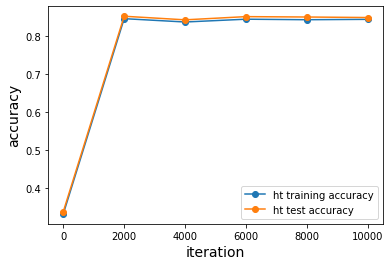

In [15]:
plt.plot(iterations, accuracies_ht_train, 'o-', label='ht training accuracy')
plt.plot(iterations, accuracies_ht_test, 'o-', label='ht test accuracy')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
plt.show()

Let's compare this evolution to that of QLearning.

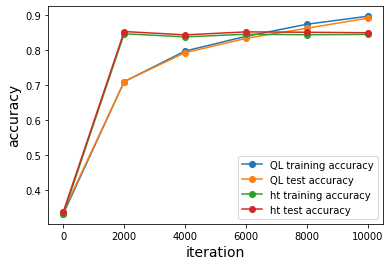

In [16]:
plt.plot(iterations, accuracies_train, 'o-', label='QL training accuracy')
plt.plot(iterations, accuracies_test, 'o-', label='QL test accuracy')
plt.plot(iterations, accuracies_ht_train, 'o-', label='ht training accuracy')
plt.plot(iterations, accuracies_ht_test, 'o-', label='ht test accuracy')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
plt.show()

HT converges faster than QLearning, but is suboptimal in this setting, while we clearly see that the performance of QLearning increases steadily and is higher at the end than the performance of HT.

### 5 folds cross-validation

In this section, we train and evaluate QLearning on the nursery dataset using a 5-folds crossvalidation.

In [9]:
kf = KFold()

In addition to training and evaluating the performance of Q-learning using 5-folds crossvalidation, we keep track of the weights during training in order to evaluate the performance evolution of the model on each fold.

In [15]:
accuracies_ql = []
accuracies_ht = []
i = 1
for train_indices, test_indices in kf.split(data, data[:, -1]):
    # QLearning
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = EnvironmentReal(data_train, rewards_queries, r_plus=5, r_minus=-10)
    agent = QLearning(categories=categories, labels=list(env_train.maps[data_train.shape[1]-1].values()), min_queries=1, max_queries=5)
    agent.train(env_train, n_episodes=data_train.shape[0], path_save='nursery_ql_'+'fold_'+str(i)+'/', n_save=data_train.shape[0]//5, 
                     epsilon_start=1, epsilon_stop=0.1, decay_rate=1e-4)
    agent.greedy_policy()
    env_test = EnvironmentReal(data_test, rewards_queries)
    accuracy = agent.test(env_test, len(test_indices))
    accuracies.append(accuracy)
    print('QL, Fold %d : accuracy=%.3f' %(i, accuracy))
    print('\n')
    i += 1
    

Episode : 0 , epsilon : 1.000
Episode : 2073 , epsilon : 0.419
Episode : 4146 , epsilon : 0.213
Episode : 6219 , epsilon : 0.140
Episode : 8292 , epsilon : 0.114
Episode : 10365 , epsilon : 0.105
Fold 1 : accuracy=0.885


Episode : 0 , epsilon : 1.000
Episode : 2073 , epsilon : 0.419
Episode : 4146 , epsilon : 0.213
Episode : 6219 , epsilon : 0.140
Episode : 8292 , epsilon : 0.114
Episode : 10365 , epsilon : 0.105
Fold 2 : accuracy=0.872


Episode : 0 , epsilon : 1.000
Episode : 2073 , epsilon : 0.419
Episode : 4146 , epsilon : 0.213
Episode : 6219 , epsilon : 0.140
Episode : 8292 , epsilon : 0.114
Episode : 10365 , epsilon : 0.105
Fold 3 : accuracy=0.873


Episode : 0 , epsilon : 1.000
Episode : 2073 , epsilon : 0.419
Episode : 4146 , epsilon : 0.213
Episode : 6219 , epsilon : 0.140
Episode : 8292 , epsilon : 0.114
Episode : 10365 , epsilon : 0.105
Fold 4 : accuracy=0.887


Episode : 0 , epsilon : 1.000
Episode : 2073 , epsilon : 0.419
Episode : 4146 , epsilon : 0.213
Episode : 6219 ,

Let's assess the evolution of the model's performance on each fold

In [10]:
path_fold = 'nursery_ql_fold_1/'
list_weights = sorted(os.listdir(path_fold), key = iteration)
accuracies_train_folds = np.empty((5, len(list_weights)))
accuracies_test_folds = np.empty((5, len(list_weights)))
accuracies_ht_train_folds = np.empty((5, len(list_weights)))
accuracies_ht_test_folds = np.empty((5, len(list_weights)))
iterations = []
for path in list_weights:
    iterations.append(iteration(path))
    
i=0
for train_indices, test_indices in kf.split(data, data[:, -1]):
    # QL
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = EnvironmentReal(data_train, rewards_queries)
    env_test = EnvironmentReal(data_test, rewards_queries)
    agent = QLearning(categories=categories, labels=list(env_train.maps[data.shape[1]-1].values()), min_queries=1, max_queries=5)
    path_fold = 'nursery_ql_fold_'+str(i+1)+'/'
    list_weights = sorted(os.listdir(path_fold), key = iteration)
    for j, path in enumerate(list_weights):
        agent.load_weights(path_fold + path)
        agent.greedy_policy()
        accuracies_train_folds[i, j] = agent.test(env_train, n_test=data_train.shape[0])
        accuracies_test_folds[i, j] = agent.test(env_test, n_test=data_test.shape[0])
        
    # HT
    X_train, Y_train = X_processed[train_indices, :], Y_processed[train_indices]
    X_test, Y_test = X_processed[test_indices, :], Y_processed[test_indices]
    ht = HoeffdingTreeClassifier()
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train_folds[i, 0] = (predictions_train == Y_train).sum()/len(predictions_train)
    accuracies_ht_test_folds[i, 0] = (predictions_test == Y_test).sum()/len(predictions_test)    
    for j in range(1, 6):
        ht.fit(X_train[j*X_train.shape[0]//5:(j+1)*X_train.shape[0]//5, :], Y_train[j*X_train.shape[0]//5:(j+1)*X_train.shape[0]//5])
        predictions_train = ht.predict(X_train)
        predictions_test = ht.predict(X_test)
        accuracies_ht_train_folds[i, j] = (predictions_train == Y_train).sum()/len(predictions_train)
        accuracies_ht_test_folds[i, j] = (predictions_test == Y_test).sum()/len(predictions_test)   
        
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train_folds[i, -1] = (predictions_train == Y_train).sum()/len(predictions_train)
    accuracies_ht_test_folds[i, -1] = (predictions_test == Y_test).sum()/len(predictions_test)
    print('Finished fold : %d' %(i+1))
    i += 1
    

Finished fold : 1
Finished fold : 2
Finished fold : 3
Finished fold : 4
Finished fold : 5


Let's compare the mean and standard deviation of the accuracy induced by the crossvalidation for the last model in both QLearning and HT.

In [21]:
print('QL, crossval mean = %.4f' %accuracies_test_folds[:, -1].mean())
print('QL, crossval std = %.4f' %accuracies_test_folds[:, -1].std())
print('HT, crossval mean = %.4f' %accuracies_ht_test_folds[:, -1].mean())
print('HT, crossval std = %.4f' %accuracies_ht_test_folds[:, -1].std())

QL, crossval mean = 0.8805
QL, crossval std = 0.0066
HT, crossval mean = 0.8428
HT, crossval std = 0.0066


The last models in both HT and QLearning achieve similar standard deviation, but QLearning has a better accuracy, $88\%$ compared to $84\%$ for HT.

Let's plot the evolution of mean the accuracy on training and testing folds along with the standard deviation.

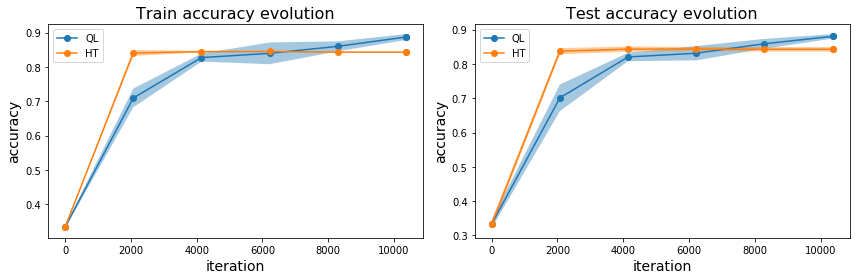

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
accuracies_train_mean, accuracies_test_mean = accuracies_train_folds.mean(axis=0), accuracies_test_folds.mean(axis=0)
accuracies_train_std, accuracies_test_std = accuracies_train_folds.std(axis=0), accuracies_test_folds.std(axis=0)
accuracies_ht_train_mean, accuracies_ht_test_mean = accuracies_ht_train_folds.mean(axis=0), accuracies_ht_test_folds.mean(axis=0)
accuracies_ht_train_std, accuracies_ht_test_std = accuracies_ht_train_folds.std(axis=0), accuracies_ht_test_folds.std(axis=0)
axs[0].plot(iterations, accuracies_train_mean, '-o', label='QL')
axs[0].plot(iterations, accuracies_ht_train_mean, '-o', label='HT')
axs[0].fill_between(iterations, accuracies_train_mean - accuracies_train_std, accuracies_train_mean + accuracies_train_std, alpha=0.4)
axs[0].fill_between(iterations, accuracies_ht_train_mean - accuracies_ht_train_std, accuracies_ht_train_mean + accuracies_ht_train_std, alpha=0.4)
axs[0].set_title('Train accuracy evolution', fontsize=16)
axs[0].set_xlabel('iteration', fontsize=14)
axs[0].set_ylabel('accuracy', fontsize=14)
axs[0].legend()
axs[1].plot(iterations, accuracies_test_mean, '-o', label='QL')
axs[1].plot(iterations, accuracies_ht_test_mean, '-o', label='HT')
axs[1].fill_between(iterations, accuracies_test_mean - accuracies_test_std, accuracies_test_mean + accuracies_test_std, alpha=0.4)
axs[1].fill_between(iterations, accuracies_ht_test_mean - accuracies_ht_test_std, accuracies_ht_test_mean + accuracies_ht_test_std, alpha=0.4)
axs[1].set_title('Test accuracy evolution', fontsize=16)
axs[1].set_xlabel('iteration', fontsize=14)
axs[1].set_ylabel('accuracy', fontsize=14)
axs[1].legend()
plt.tight_layout()
plt.savefig('../fig/q_learning_nursery_folds.png')
plt.show()

Notice that HT is faster to converge and has a more stable training across the folds, however, QLearning does surpass the accuracy of HT at the end of training and it also has a very stable training across the folds.

## Mushroom Dataset

In the mushroom dataset, we deal with a binary classification problem with 22 attributes such that $k_0=7, k_1=6, k_2=9, k_3=5, k_4=3, k_5=4, k_6=1, k_7=9, k_8=9, k_9=4, k_{10}=4, k_{11}=5, k_{12}=2, k_{13}=12, k_{14}=2, k_{15}=2, k_{16}=2, k_{17}=9, k_{18}=2, k_{19}=10, k_{20}=4, k_{21}=6$, hence the state space size is $|\mathcal{S}| = 121899810816000$ which is too big for a simple Q-learning. Thus we will apply DQN and Advantage Actor-Critic to solve the problem.

Let's start by loading the data and split it into training and testing data sets. Then we deduce the categories from the training set and define the rewards of queries.

In [2]:
data = np.genfromtxt('../data/agaricus-lepiota.data', delimiter=',', dtype=str)
data = data[:, ::-1]
np.random.seed(0)
np.random.shuffle(data)
data_train, data_test = data[:6000, :], data[6000:, :]

In [3]:
categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
rewards_queries = dict([(i, -.5) for i in range(len(categories))])
encoder = Encoder(categories=categories)

### DQN

Now let's define the environment and the DQN agent.

In [4]:
env = EnvironmentReal(data_train, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10)
agent = DQN(categories=categories, labels=list(env.maps[data.shape[1]-1].values()), max_size_queries=int(1e5), max_size_reports=int(1e4))

We are ready to train the model, we will make two passes over the data stream induced from the whole training set.

In [5]:
agent.train(env, n_episodes=data_train.shape[0], n_pretrain=512, n_learn=10, max_tau=50, decay_rate=1e-5, 
            lr=1e-3, batch_size=256, path_save='mushroom_dqn/', log_dir='runs_mushroom_dqn/')

Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.802
Episode : 2000, epsilon : 0.644
Episode : 3000, epsilon : 0.517
Episode : 4000, epsilon : 0.415
Episode : 5000, epsilon : 0.333


Let's define the test environment and evaluate the model on unseen real data.

In [6]:
env_test = EnvironmentReal(data_test, rewards_queries, encoder=encoder)
print("accuracy=%.3f" %(agent.test(env_test, data_test.shape[0])))

accuracy=0.982


We can visualize the decision tree that the agent converged to below.

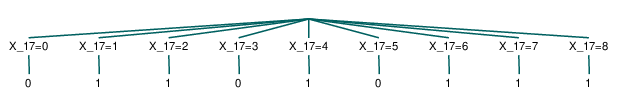

In [7]:
agent.plot_tree(encoder)

In [8]:
accuracies_train = []
accuracies_test = []
iterations = []
list_weights = sorted(os.listdir('mushroom_dqn/'), key = iteration)

In [9]:
for i, path in enumerate(list_weights):
    agent.load_weights('mushroom_dqn/' + path)
    accuracies_train.append(agent.test(env, n_test=data_train.shape[0]))
    accuracies_test.append(agent.test(env_test, n_test=data_test.shape[0]))
    iterations.append(iteration(path))

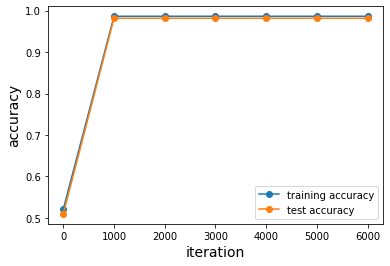

In [10]:
plt.plot(iterations, accuracies_train, 'o-', label='training accuracy')
plt.plot(iterations, accuracies_test, 'o-', label='test accuracy')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
plt.show()

In [9]:
# Let's make a processed copy of data containing only numerical values
# We need this processed copy in order to use HT
X_processed, Y_processed = np.empty_like(data[:, :-1], dtype=np.int), np.empty_like(data[:, -1], dtype=np.int)
for i in range(len(Y_processed)):
    a, b = env.preprocess(data[i, :])
    X_processed[i, :], Y_processed[i] = np.array(a, dtype=np.int), int(b)
    
X_train, Y_train = X_processed[:6000, :], Y_processed[:6000]
X_test, Y_test = X_processed[6000:, :], Y_processed[6000:]

In [12]:
ht = HoeffdingTreeClassifier()
ht.fit(X_train, Y_train)
predictions = ht.predict(X_test)
print("accuracy=%.4f" %((predictions == Y_test).sum()/len(predictions)))

accuracy=0.9308


In [13]:
ht = HoeffdingTreeClassifier()
accuracies_ht_train, accuracies_ht_test = [], []
predictions_train = ht.predict(X_train)
predictions_test = ht.predict(X_test)
accuracies_ht_train.append((predictions_train == Y_train).sum()/len(predictions_train))
accuracies_ht_test.append((predictions_test == Y_test).sum()/len(predictions_test))

In [14]:
for i in range(6):
    ht.fit(X_train[i*1000:(i+1)*1000, :], Y_train[i*1000:(i+1)*1000])
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train.append((predictions_train == Y_train).sum()/len(predictions_train))
    accuracies_ht_test.append((predictions_test == Y_test).sum()/len(predictions_test))

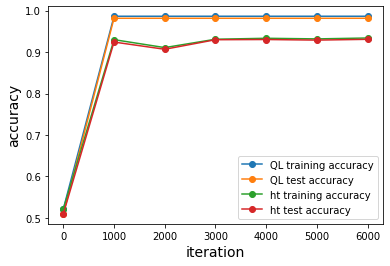

In [16]:
plt.plot(iterations, accuracies_train, 'o-', label='QL training accuracy')
plt.plot(iterations, accuracies_test, 'o-', label='QL test accuracy')
plt.plot(iterations, accuracies_ht_train, 'o-', label='ht training accuracy')
plt.plot(iterations, accuracies_ht_test, 'o-', label='ht test accuracy')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
plt.show()

In this experiment, DQN is clearly faster (in terms of the number of processed samples) to converge, and it also achieves a superior accuracy of $98\%$ while HT achieves $93\%$

### 5 folds cross-validation

In [18]:
kf = KFold()

In [21]:
accuracies = []
i = 1
for train_indices, test_indices in kf.split(data, data[:, -1]):
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    encoder = Encoder(categories=categories)
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = EnvironmentReal(data_train, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10)
    agent = DQN(categories=categories, labels=list(env_train.maps[data.shape[1]-1].values()), max_size_queries=int(1e5), max_size_reports=int(1e4))
    agent.train(env_train, n_episodes=data_train.shape[0], n_pretrain=512, n_learn=10, max_tau=50, decay_rate=1e-5, lr=1e-3, batch_size=256, 
                path_save='mushroom_dqn_fold_'+str(i)+'/', log_dir='runs_mushroom_dqn_fold_'+str(i)+'/')
    env_test = EnvironmentReal(data_test, rewards_queries, encoder=encoder)
    accuracy = agent.test(env_test, len(test_indices))
    accuracies.append(accuracy)
    print('Fold %d : accuracy=%.3f' %(i, accuracy))
    print('\n')
    i += 1
    

Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.802
Episode : 2000, epsilon : 0.644
Episode : 3000, epsilon : 0.517
Episode : 4000, epsilon : 0.415
Episode : 5000, epsilon : 0.333
Episode : 6000, epsilon : 0.267
Fold 1 : accuracy=0.988


Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.802
Episode : 2000, epsilon : 0.644
Episode : 3000, epsilon : 0.517
Episode : 4000, epsilon : 0.415
Episode : 5000, epsilon : 0.333
Episode : 6000, epsilon : 0.267
Fold 2 : accuracy=0.984


Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.802
Episode : 2000, epsilon : 0.644
Episode : 3000, epsilon : 0.517
Episode : 4000, epsilon : 0.415
Episode : 5000, epsilon : 0.333
Episode : 6000, epsilon : 0.267
Fold 3 : accuracy=0.988


Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.802
Episode : 2000, epsilon : 0.644
Episode : 3000, epsilon : 0.517
Episode : 4000, epsilon : 0.415
Episode : 5000, epsilon : 0.333
Episode : 6000, epsilon : 0.267
Fold 4 : accuracy=0.984


Episode : 0,

In [42]:
path_fold = 'mushroom_dqn_fold_1/'
list_weights = sorted(os.listdir(path_fold), key = iteration)
accuracies_train_folds = np.empty((5, len(list_weights)))
accuracies_test_folds = np.empty((5, len(list_weights)))
accuracies_ht_train_folds = np.empty((5, len(list_weights)))
accuracies_ht_test_folds = np.empty((5, len(list_weights)))
iterations = []
for path in list_weights:
    iterations.append(iteration(path))
    
i=0
for train_indices, test_indices in kf.split(data, data[:, -1]):
    # DQN
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    encoder = Encoder(categories=categories)
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = EnvironmentReal(data_train, rewards_queries, encoder=encoder)
    env_test = EnvironmentReal(data_test, rewards_queries, encoder=encoder)
    agent = DQN(categories=categories, labels=list(env_train.maps[data_train.shape[1]-1].values()), max_size_queries=int(1e5), max_size_reports=int(1e4))
    path_fold = 'mushroom_dqn_fold_'+str(i+1)+'/'
    list_weights = sorted(os.listdir(path_fold), key = iteration)
    for j, path in enumerate(list_weights):
        agent.load_weights(path_fold + path)
        accuracies_train_folds[i, j] = agent.test(env_train, n_test=data_train.shape[0])
        accuracies_test_folds[i, j] = agent.test(env_test, n_test=data_test.shape[0])
        
    # HT
    X_train, Y_train = X_processed[train_indices, :], Y_processed[train_indices]
    X_test, Y_test = X_processed[test_indices, :], Y_processed[test_indices]
    ht = HoeffdingTreeClassifier()
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train_folds[i, 0] = (predictions_train == Y_train).sum()/len(predictions_train)
    accuracies_ht_test_folds[i, 0] = (predictions_test == Y_test).sum()/len(predictions_test)    
    for j in range(1, 7):
        ht.fit(X_train[j*1000:(j+1)*1000, :], Y_train[j*1000:(j+1)*1000])
        predictions_train = ht.predict(X_train)
        predictions_test = ht.predict(X_test)
        accuracies_ht_train_folds[i, j] = (predictions_train == Y_train).sum()/len(predictions_train)
        accuracies_ht_test_folds[i, j] = (predictions_test == Y_test).sum()/len(predictions_test)   
        
    ht.fit(X_train[6000:, :], Y_train[6000:])
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train_folds[i, -1] = (predictions_train == Y_train).sum()/len(predictions_train)
    accuracies_ht_test_folds[i, -1] = (predictions_test == Y_test).sum()/len(predictions_test)

        
    print('Finished fold : %d' %(i+1))
    i += 1
    

Finished fold : 1
Finished fold : 2
Finished fold : 3
Finished fold : 4
Finished fold : 5


### Advantage Actor-Critic

Let's define the environment and the Advantage Actor-Critic agent.

In [4]:
env = EnvironmentReal(data_train, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10)
agent = ActorCritic(categories=categories, labels=list(env.maps[data_train.shape[1]-1].values()), min_queries=1)

We are ready to train the model, unlike DQN, we will make three passes over the data stream induced from the whole training set, this is because DQN learns from more data with its experience replay while Actor Critic learns from each data point at a time.

In [5]:
agent.train(env, n_episodes=data_train.shape[0], lr=1e-3, lambd=0.5, max_step=30, log_dir='runs_mushroom_ac/', 
            path_save='mushroom_ac/')

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000


Let's define the test environment and evaluate the model on unseen real data.

In [6]:
env_test = EnvironmentReal(data_test, rewards_queries, encoder=encoder)
print("accuracy=%.3f" %(agent.test(env_test, data_test.shape[0])))

accuracy=0.982


We can visualize the decision tree that the agent converged to below.

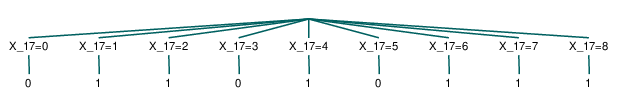

In [7]:
agent.plot_tree(encoder)

In [20]:
accuracies_train = []
accuracies_test = []
iterations = []
list_weights = sorted(os.listdir('mushroom_ac/'), key = iteration)

In [21]:
for i, path in enumerate(list_weights):
    agent.load_weights('mushroom_ac/' + path)
    accuracies_train.append(agent.test(env, n_test=data_train.shape[0]))
    accuracies_test.append(agent.test(env_test, n_test=data_test.shape[0]))
    iterations.append(iteration(path))

In [23]:
# Let's make a processed copy of data containing only numerical values
# We need this processed copy in order to use HT
X_processed, Y_processed = np.empty_like(data[:, :-1], dtype=np.int), np.empty_like(data[:, -1], dtype=np.int)
for i in range(len(Y_processed)):
    a, b = env.preprocess(data[i, :])
    X_processed[i, :], Y_processed[i] = np.array(a, dtype=np.int), int(b)
    
X_train, Y_train = X_processed[:6000, :], Y_processed[:6000]
X_test, Y_test = X_processed[6000:, :], Y_processed[6000:]

In [24]:
ht = HoeffdingTreeClassifier()
accuracies_ht_train, accuracies_ht_test = [], []
predictions_train = ht.predict(X_train)
predictions_test = ht.predict(X_test)
accuracies_ht_train.append((predictions_train == Y_train).sum()/len(predictions_train))
accuracies_ht_test.append((predictions_test == Y_test).sum()/len(predictions_test))

In [25]:
for i in range(6):
    ht.fit(X_train[i*1000:(i+1)*1000, :], Y_train[i*1000:(i+1)*1000])
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train.append((predictions_train == Y_train).sum()/len(predictions_train))
    accuracies_ht_test.append((predictions_test == Y_test).sum()/len(predictions_test))

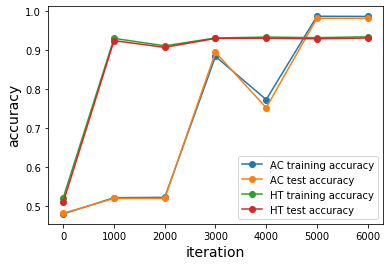

In [26]:
plt.plot(iterations, accuracies_train, 'o-', label='AC training accuracy')
plt.plot(iterations, accuracies_test, 'o-', label='AC test accuracy')
plt.plot(iterations, accuracies_ht_train, 'o-', label='HT training accuracy')
plt.plot(iterations, accuracies_ht_test, 'o-', label='HT test accuracy')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
plt.show()

### 5 folds cross-validation

In [5]:
kf = KFold()

In [6]:
accuracies = []
i = 1
for train_indices, test_indices in kf.split(data, data[:, -1]):
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    encoder = Encoder(categories=categories)
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = EnvironmentReal(data_train, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10)
    agent = ActorCritic(categories=categories, labels=list(env.maps[data_train.shape[1]-1].values()), min_queries=1)
    agent.train(env_train, n_episodes=data_train.shape[0], lr=1e-3, lambd=0.5, max_step=30, log_dir='runs_mushroom_ac_fold_'+str(i)+'/', 
            path_save='mushroom_ac_fold_'+str(i)+'/')
    env_test = EnvironmentReal(data_test, rewards_queries, encoder=encoder)
    accuracy = agent.test(env_test, len(test_indices))
    accuracies.append(accuracy)
    print('Fold %d : accuracy=%.3f' %(i, accuracy))
    print('\n')
    i += 1
    

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Fold 1 : accuracy=0.988


Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Fold 2 : accuracy=0.931


Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Fold 3 : accuracy=0.988


Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Fold 4 : accuracy=0.984


Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Fold 5 : accuracy=0.982




## Comparing DQN, AC and HT on a 5 folds crossvalidation

In [10]:
path_fold_dqn = 'mushroom_dqn_fold_1/'
path_fold_ac = 'mushroom_ac_fold_1/'
list_weights_dqn = sorted(os.listdir(path_fold_dqn), key = iteration)
list_weights_ac = sorted(os.listdir(path_fold_ac), key = iteration)

accuracies_dqn_train_folds = np.empty((5, len(list_weights_dqn)))
accuracies_dqn_test_folds = np.empty((5, len(list_weights_dqn)))
accuracies_ac_train_folds = np.empty((5, len(list_weights_ac)))
accuracies_ac_test_folds = np.empty((5, len(list_weights_ac)))
accuracies_ht_train_folds = np.empty((5, len(list_weights_dqn)))
accuracies_ht_test_folds = np.empty((5, len(list_weights_dqn)))

iterations = []
for path in list_weights_dqn:
    iterations.append(iteration(path))
    
i=0
for train_indices, test_indices in kf.split(data, data[:, -1]):
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    encoder = Encoder(categories=categories)
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = EnvironmentReal(data_train, rewards_queries, encoder=encoder)
    env_test = EnvironmentReal(data_test, rewards_queries, encoder=encoder)

    # DQN
    agent = DQN(categories=categories, labels=list(env_train.maps[data_train.shape[1]-1].values()), max_size_queries=int(1e5), max_size_reports=int(1e4))
    path_fold = 'mushroom_dqn_fold_'+str(i+1)+'/'
    list_weights = sorted(os.listdir(path_fold), key = iteration)
    for j, path in enumerate(list_weights):
        agent.load_weights(path_fold + path)
        accuracies_dqn_train_folds[i, j] = agent.test(env_train, n_test=data_train.shape[0])
        accuracies_dqn_test_folds[i, j] = agent.test(env_test, n_test=data_test.shape[0])
        
    # AC
    agent = ActorCritic(categories=categories, labels=list(env_train.maps[data_train.shape[1]-1].values()), min_queries=1)
    path_fold = 'mushroom_ac_fold_'+str(i+1)+'/'
    list_weights = sorted(os.listdir(path_fold), key = iteration)
    for j, path in enumerate(list_weights):
        agent.load_weights(path_fold + path)
        accuracies_ac_train_folds[i, j] = agent.test(env_train, n_test=data_train.shape[0])
        accuracies_ac_test_folds[i, j] = agent.test(env_test, n_test=data_test.shape[0])
        
    # HT
    X_train, Y_train = X_processed[train_indices, :], Y_processed[train_indices]
    X_test, Y_test = X_processed[test_indices, :], Y_processed[test_indices]
    ht = HoeffdingTreeClassifier()
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train_folds[i, 0] = (predictions_train == Y_train).sum()/len(predictions_train)
    accuracies_ht_test_folds[i, 0] = (predictions_test == Y_test).sum()/len(predictions_test)    
    for j in range(1, 7):
        ht.fit(X_train[j*1000:(j+1)*1000, :], Y_train[j*1000:(j+1)*1000])
        predictions_train = ht.predict(X_train)
        predictions_test = ht.predict(X_test)
        accuracies_ht_train_folds[i, j] = (predictions_train == Y_train).sum()/len(predictions_train)
        accuracies_ht_test_folds[i, j] = (predictions_test == Y_test).sum()/len(predictions_test)   
        
    ht.fit(X_train[6000:, :], Y_train[6000:])
    predictions_train = ht.predict(X_train)
    predictions_test = ht.predict(X_test)
    accuracies_ht_train_folds[i, -1] = (predictions_train == Y_train).sum()/len(predictions_train)
    accuracies_ht_test_folds[i, -1] = (predictions_test == Y_test).sum()/len(predictions_test)
        
    print('Finished fold : %d' %(i+1))
    i += 1
    

Finished fold : 1
Finished fold : 2
Finished fold : 3
Finished fold : 4
Finished fold : 5


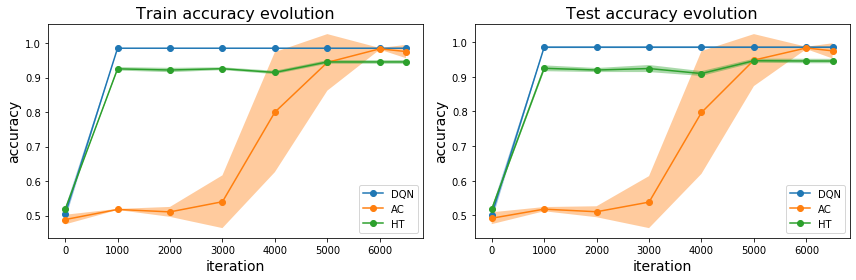

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

accuracies_dqn_train_mean, accuracies_dqn_test_mean = accuracies_dqn_train_folds.mean(axis=0), accuracies_dqn_test_folds.mean(axis=0)
accuracies_dqn_train_std, accuracies_dqn_test_std = accuracies_dqn_train_folds.std(axis=0), accuracies_dqn_test_folds.std(axis=0)
accuracies_ac_train_mean, accuracies_ac_test_mean = accuracies_ac_train_folds.mean(axis=0), accuracies_ac_test_folds.mean(axis=0)
accuracies_ac_train_std, accuracies_ac_test_std = accuracies_ac_train_folds.std(axis=0), accuracies_ac_test_folds.std(axis=0)
accuracies_ht_train_mean, accuracies_ht_test_mean = accuracies_ht_train_folds.mean(axis=0), accuracies_ht_test_folds.mean(axis=0)
accuracies_ht_train_std, accuracies_ht_test_std = accuracies_ht_train_folds.std(axis=0), accuracies_ht_test_folds.std(axis=0)

axs[0].plot(iterations, accuracies_dqn_train_mean, '-o', label='DQN')
axs[0].plot(iterations, accuracies_ac_train_mean, '-o', label='AC')
axs[0].plot(iterations, accuracies_ht_train_mean, '-o', label='HT')
axs[0].fill_between(iterations, accuracies_dqn_train_mean - accuracies_dqn_train_std, accuracies_dqn_train_mean + accuracies_dqn_train_std, alpha=0.4)
axs[0].fill_between(iterations, accuracies_ac_train_mean - accuracies_ac_train_std, accuracies_ac_train_mean + accuracies_ac_train_std, alpha=0.4)
axs[0].fill_between(iterations, accuracies_ht_train_mean - accuracies_ht_train_std, accuracies_ht_train_mean + accuracies_ht_train_std, alpha=0.4)
axs[0].set_title('Train accuracy evolution', fontsize=16)
axs[0].set_xlabel('iteration', fontsize=14)
axs[0].set_ylabel('accuracy', fontsize=14)
axs[0].legend()

axs[1].plot(iterations, accuracies_dqn_test_mean, '-o', label='DQN')
axs[1].plot(iterations, accuracies_ac_test_mean, '-o', label='AC')
axs[1].plot(iterations, accuracies_ht_test_mean, '-o', label='HT')
axs[1].fill_between(iterations, accuracies_dqn_test_mean - accuracies_dqn_test_std, accuracies_dqn_test_mean + accuracies_dqn_test_std, alpha=0.4)
axs[1].fill_between(iterations, accuracies_ac_test_mean - accuracies_ac_test_std, accuracies_ac_test_mean + accuracies_ac_test_std, alpha=0.4)
axs[1].fill_between(iterations, accuracies_ht_test_mean - accuracies_ht_test_std, accuracies_ht_test_mean + accuracies_ht_test_std, alpha=0.4)
axs[1].set_title('Test accuracy evolution', fontsize=16)
axs[1].set_xlabel('iteration', fontsize=14)
axs[1].set_ylabel('accuracy', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.savefig('../fig/compare_mushrooms_folds.png')
plt.show()

In [14]:
print("AC, mean accuracy : %.4f" %accuracies_ac_test_mean[-1])
print("AC, std accuracy : %.4f" %accuracies_ac_test_std[-1])
print("DQN, mean accuracy : %.4f" %accuracies_dqn_test_mean[-1])
print("DQN, std accuracy : %.4f" %accuracies_dqn_test_std[-1])
print("HT, mean accuracy : %.4f" %accuracies_ht_test_mean[-1])
print("HT, std accuracy : %.4f" %accuracies_ht_test_std[-1])

AC, mean accuracy : 0.9746
AC, std accuracy : 0.0219
DQN, mean accuracy : 0.9852
DQN, std accuracy : 0.0027
HT, mean accuracy : 0.9453
HT, std accuracy : 0.0063
